# Problem Description
The problem I chose to address for this final project is a real world scenario at my current company. For that reason I won't be able to share the data and some of the EDA print outs will be limited, but I can share the EDA and modeling techniques I employ and how successful they are in making predictions. 

At my company transactions typically get classified into a certain type. The problem is that many are either not classified correctly or not classified at all. The issue stems from the fact that the people ultimately responsible for selecting the classification are not always familiar with the actual transaction or the context surrouding it. Furthermore, they are pressured by time constraints and goals that don't allow them the opportunity to adequately research the transaction, they simply have to make educated guesses and move on. It's too time consuming and the resources don't exist to review these transactions to adjust their classification after they've initially been processed, and the inaccuracies cause issues within the company related to operations and planning and impact our costs. For this reason, I thought it would be a perfect opportunity to explore potential improvements that machine learning might be able to provide. 

Many of the transactions include some sort of description of what the transaction was. In reality, these descriptions are not used by the people making the classification determination because of the afore-mentioned time-constraints. The goal of this project is to use the text from the descriptions of each transaction to help classify those transactions that are not currently classified in our system.  

There is a hierarchical structure of classifications: there is a parent class and then a child class which is much more detailed. For this project, I will only seek to classify transactions in the parent class.

# Exploratory Data Analysis

In [28]:
# do the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from collections import Counter

The dataset is very large, so to improve efficiency I'll only load the two applicable columns required: the Item Description, which is what I'll be using for classification, and the Mapped Category, which contains the existing classifications.

In [29]:
# import the data
# only import certain columns for now
df = pd.read_csv("transactions.csv",
                 usecols=['Item Description', 'Mapped Category'])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Item Description  850291 non-null   object
 1   Mapped Category   1048575 non-null  object
dtypes: object(2)
memory usage: 16.0+ MB
None


From inspecting the data, we can see that there are a significant amount of null values in the Item Description column. We'll clean the dataset by removing those observations since we need the description text to generate predictions. 

The data includes transactions that are already categorized and those that aren't. The ultimate goal of this project is to predict the categories for those transactions that are not currently classified - but the evaluation of those predictions will require human input that is beyond the scope of this project. So I will instead remove the uncategorized rows, and break out the remaining data into a training and test set to evaluate the model's performance. The parent/child classifcations are grouped together in the Mapped Category field, so those need to be split into two new fields in order to analyze only the parent category.  

In [30]:
# drop the rows with null values in the description
df = df.dropna(subset=['Item Description'])
# drop the items that don't have a mapped category. Those will ultimately be tested 
# later by the appropriate individuals
df = df[df['Mapped Category'] != 'Not Applicable'] # Not Applicable is the default for unclassified

df[['parent_category', 'child_category']] = df['Mapped Category'].str.split('-', n=1, expand=True)
df['parent_category'] = df['parent_category'].str.strip()
df = df.drop(columns=['Mapped Category', 'child_category'])

Lastly, I created a category ID field, category_id, to encode the categorical variables from parent_catgory into numerical values so that we can use the numerical values in the model later. 

In [31]:
label_encoder = LabelEncoder()
df['category_id'] = label_encoder.fit_transform(df['parent_category'])
# view the mapping
print(df[['parent_category', 'category_id']].drop_duplicates().sort_values(by='category_id'))

              parent_category  category_id
21032                   Capex            0
31270      Financial Services            1
33104                     HRM            2
31245                     ICT            3
160596           Intercompany            4
55981               Marketing            5
58589                   Other            6
31876   Professional Services            7
48140                     S&R            8
31332          Subcontracting            9
59954         Temporary Staff           10
31377                  Travel           11
31933               Workplace           12


The dataframe has been modified appropriately. I next inspected the number of transactions in each parent category to see how they're distributed. 

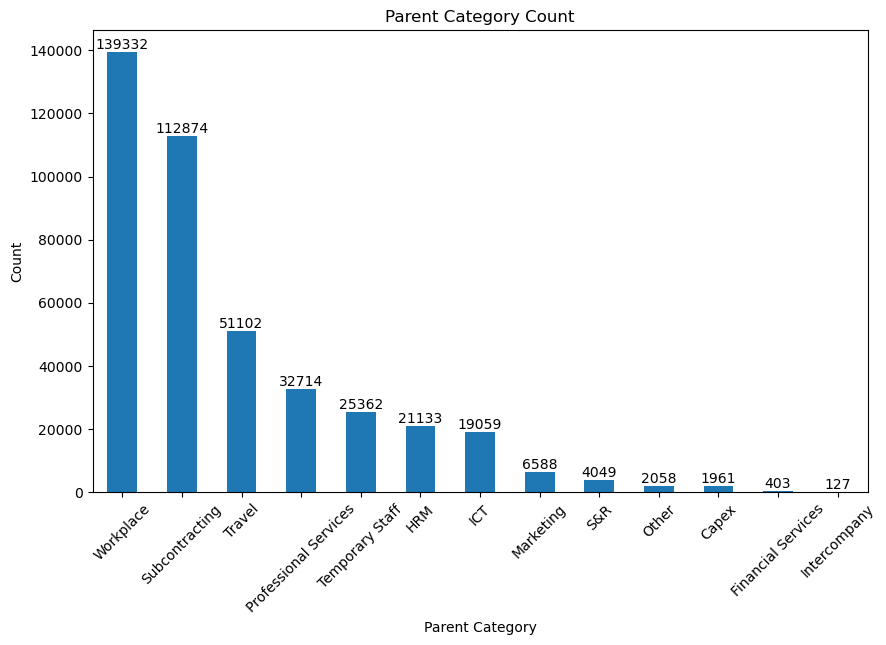

In [32]:
# Create the bar plot
parent_cat_count = df['parent_category'].value_counts()
ax = parent_cat_count.plot(kind='bar', figsize=(10, 6))  # Corrected line

# Add the actual counts to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Show the plot
plt.title('Parent Category Count')
plt.xlabel('Parent Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


The transactions are clearly not evenly distributed. But having domain knowledge of our business, this makes sense. I know the discrepancy in the distribution may lead to issues, those will be addressed later on. 

The next step I took was to reduce the dimensions and review the clustering of the observations by parent category. To do this, I converted the text from Item Description into numeric features using sklearn's TF-IDF method. TF-ID stands for term frequency, inverse document frequency. In short, it calculates a score that represents the importance of a word in a document by factoring its frequency of occurence in each document as well as its frequency of occurence across all documents, with the ability to adjust for non-important words (called 'stop words') and document length. See the link below for a more detailed explanation. https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=play%20it%20is.-,Definition,document%20or%20a%20web%20page.

<Axes: xlabel='pca_1', ylabel='pca_2'>

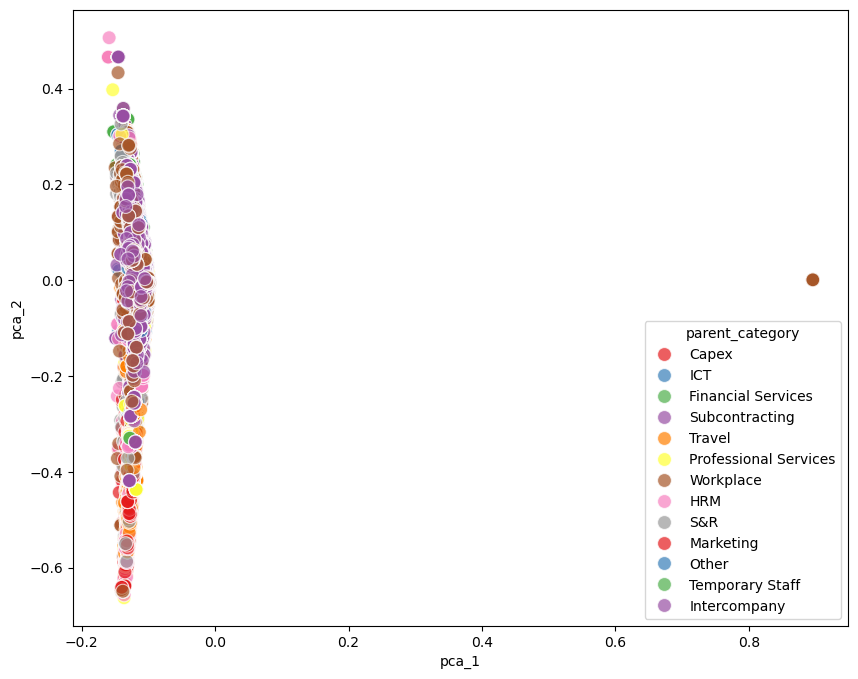

In [33]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Item Description'])

# use PCA to reduce the dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# add the PCA results to the dataframe
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sb.scatterplot(x='pca_1', y='pca_2',
              hue='parent_category',
              palette='Set1',
              data=df,
              s=100,
              alpha=0.7)

From the plot above, the data doesn't appear to be clustered well for classification; there are a few reason this may be the case that can be accounted for, they are addressed individually below. 

# Sparse or high-dimensional data: 
The data could be sparse or high-dimensional. To solve for this I attempted to reduce the dimensionality futher by tuning the parameters of the TfidfVectorizer, again applying PCA to reduce the dimensionality, and then further reducing the dimensions using t-SNE. I also implemented the lemmatization technique, where words are reduced into their root form. The resulting clusters certainly changed shape, but unfortunately are not aligned any better to make predictions, there actually appears to be less separation. 

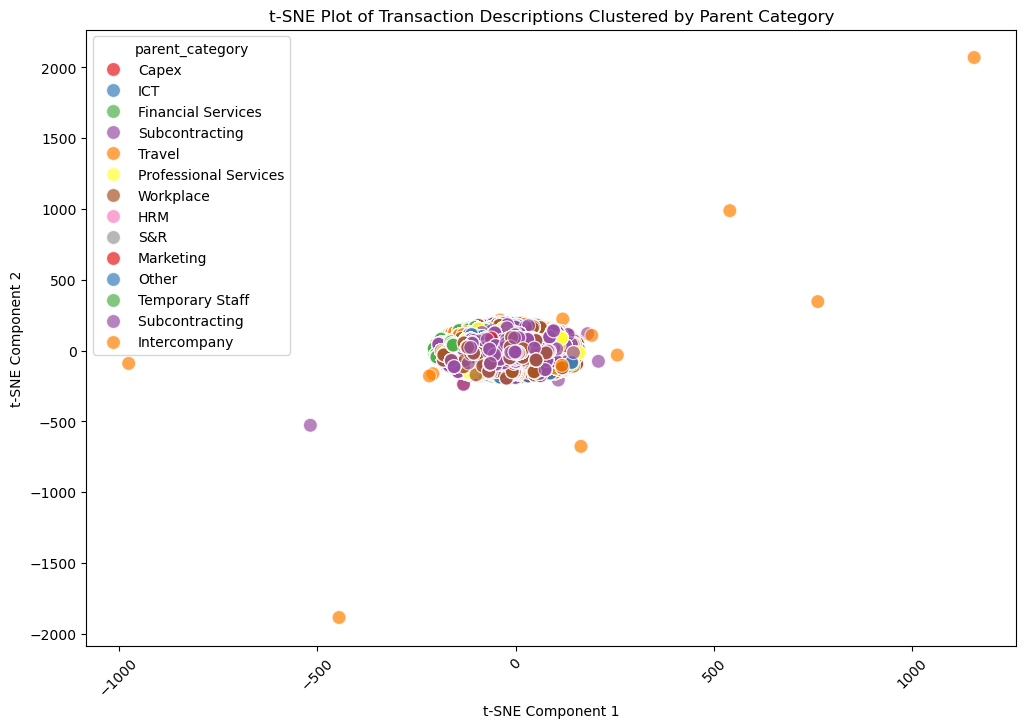

In [21]:
import spacy
from sklearn.manifold import TSNE


nlp = spacy.load('en_core_web_sm')

# implement lemmatization
def preprocess_text(text):
    doc = nlp(text.lower())
    return ' '.join([token.lemma_ for token in doc if not token.is_punct])

df['cleaned_description'] = df['Item Description'].apply(preprocess_text)

# redo the vectorization
vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.9)
X = vectorizer.fit_transform(df['cleaned_description'])

# Apply PCA to reduce dimensions first
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X.toarray())

# Apply t-SNE for to further reduce the dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Add t-SNE results to the dataframe
df['tsne_1'] = X_tsne[:, 0]
df['tsne_2'] = X_tsne[:, 1]

# Merge with original parent categories
df['parent_category'] = df['parent_category'] 

# Plot the t-SNE results
plt.figure(figsize=(12, 8))
sb.scatterplot(x='tsne_1', y='tsne_2', hue='parent_category', palette='Set1', data=df, s=100, alpha=0.7)
plt.title('t-SNE Plot of Transaction Descriptions Clustered by Parent Category')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.xticks(rotation=45)
plt.show()


# Feature scaling
If the features vary greatly in terms of their scale, this might result in a poorly separated 2D plot. PCA and t-SNE are sensitive to the scale of the features. To solve for this I attempted to scale the features before applying PCA. The resulting plot was an improvement, but only a minor improvement. 

<Axes: xlabel='pca_1', ylabel='pca_2'>

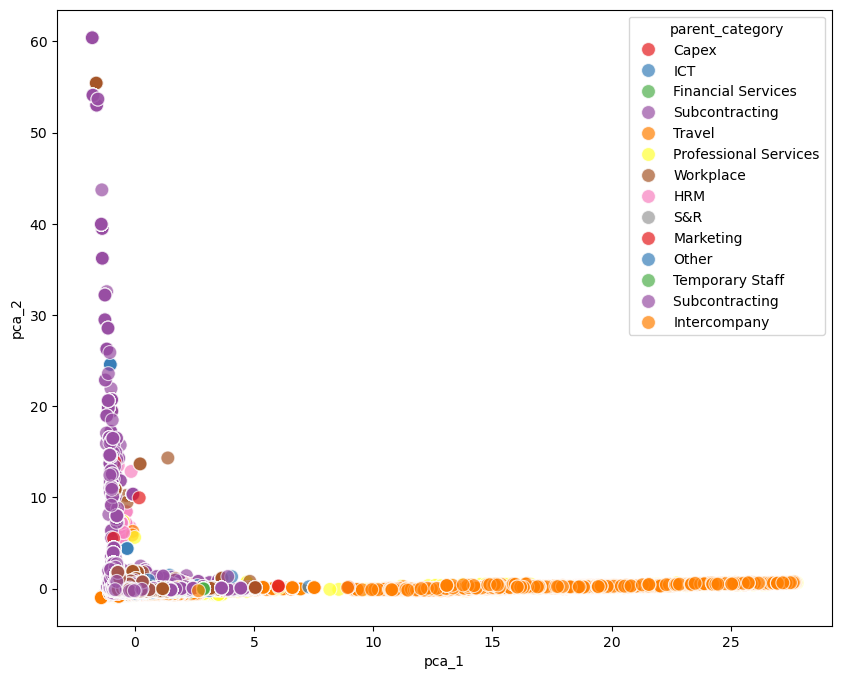

In [10]:
from sklearn.preprocessing import StandardScaler

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Item Description'])
# Standardize the data
X_scaled = StandardScaler().fit_transform(X.toarray())
# use PCA to reduce the dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# add the PCA results to the dataframe
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sb.scatterplot(x='pca_1', y='pca_2',
              hue='parent_category',
              palette='Set1',
              data=df,
              s=100,
              alpha=0.7)

# Feature set is too small
If the number of features is too small (i.e. max_features is set too low in the TfidfVectorizer), then it's possible that there's not enough information to distinguish between the parent_categories. To solve for this, I increased the max_features ten-fold from the previous vectorizer and removed the stop words argument. The resulting plot is no better than the original plot that I was hoping to improve. 

<Axes: xlabel='pca_1', ylabel='pca_2'>

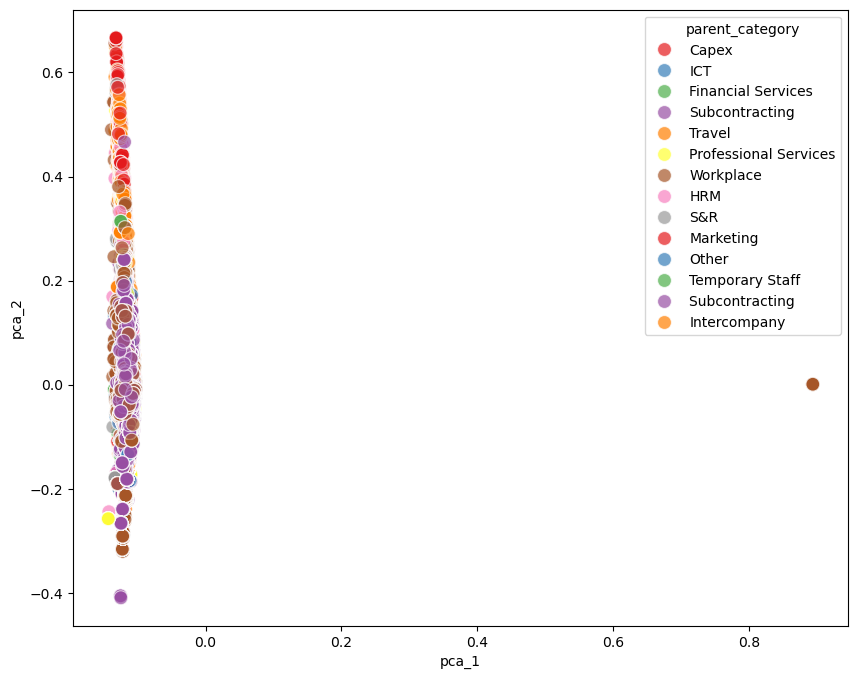

In [11]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(df['Item Description'])

# use PCA to reduce the dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# add the PCA results to the dataframe
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
sb.scatterplot(x='pca_1', y='pca_2',
              hue='parent_category',
              palette='Set1',
              data=df,
              s=100,
              alpha=0.7)

# Major imbalances in the distribution of the categories
As was noted before, there is a large imbalance in the distribution of the parent_categories, which very likely is causing issues. To solve for the imbalance I opted to oversample the data in an attempt to balance the distribution of the transactions into each parent_category. For this I used the SMOTE technique. I also again used the StandardScaler method to standardize the feature matrix while oversampling the under-represented data. 

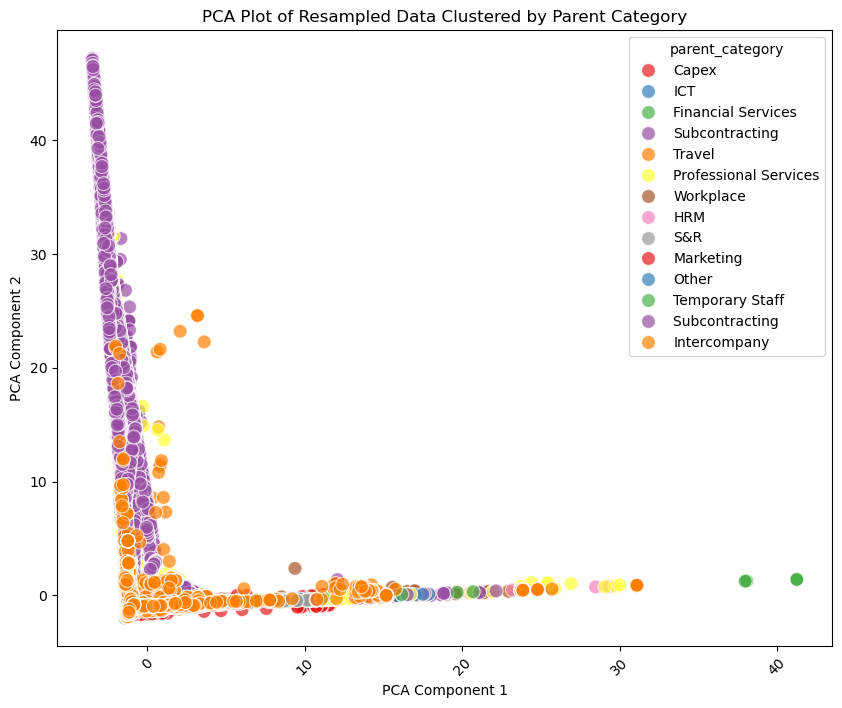

In [15]:
from imblearn.over_sampling import SMOTE

# First, vectorize the text descriptions (same as before)
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Item Description'])

# Standardize the data for PCA
X_scaled = StandardScaler().fit_transform(X.toarray())

# Apply SMOTE for oversampling the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, df['category_id'])

# Apply PCA to the resampled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Add the PCA results back to the dataframe
df_resampled = pd.DataFrame(X_pca, columns=['pca_1', 'pca_2'])
df_resampled['category_id'] = y_resampled

# Merge with the original dataframe to get the parent_category labels
df_resampled['parent_category'] = df_resampled['category_id'].map(dict(enumerate(label_encoder.classes_)))

# Now plot the clustered data
plt.figure(figsize=(10, 8))
sb.scatterplot(x='pca_1', y='pca_2',
               hue='parent_category', 
               palette='Set1', 
               data=df_resampled, 
               s=100, 
               alpha=0.7)

plt.title('PCA Plot of Resampled Data Clustered by Parent Category')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.xticks(rotation=45)
plt.show()


Oversampling helped to improve the clustering, but it's still far from ideal. The result is similar to the result from feature scaling alone. Though I wasn't able to achieve the clustering I was hoping for, I opted to proceed with model building and testing based on the oversampling technique above. 

# Training, Building, and Testing the Model
I chose to use matrix factorization and apply Single Value Decomposition (SVD) to predict the categories in this data set. The reason I opted to use this method rather than the Non-negative Matrix Factorization (NMF) method is because the scaling yielded negative values that cannot be utilized in an NMF model. 

In [48]:
# Recreate the vector using tfidf
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Item Description'])

# Standardize the data agin
X_scaled = StandardScaler().fit_transform(X.toarray())

X_train, X_test, y_train, y_test = train_test_split(X_scaled, df['parent_category'], test_size=0.2, random_state=42)

svd = TruncatedSVD(n_components=10, random_state=42)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

n_clusters = len(np.unique(y_train))

# Ensure that n_clusters does not exceed the number of training samples
n_clusters = min(n_clusters, len(X_train))  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_train_svd)

y_pred = kmeans.predict(X_test_svd)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# assign the cluster labels to the most common true label in each cluster
cluster_to_label = {}

# Iterate through each cluster and assign it the most frequent true label
for cluster in range(kmeans.n_clusters):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0] 
    true_labels_in_cluster = y_train_encoded[cluster_indices]
    
    if len(true_labels_in_cluster) > 0:  
        most_frequent_label = Counter(true_labels_in_cluster).most_common(1)[0][0]
        cluster_to_label[cluster] = most_frequent_label

# map predicted cluster labels to true labels (decoded back to string labels)
y_pred_mapped = [cluster_to_label.get(label, -1) for label in y_pred]  # Default to -1 if label is not found
y_pred_mapped = label_encoder.inverse_transform(y_pred_mapped)

# calculate and print out the accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.3842


# Results
With an accuracy score of 0.3842, the model did not do a good job of correctly predicting the categories of the transactions based on the item description field. Based on what was seen in the EDA phase, this is not surprising. I pretty confident that the issue here is the data being used for predictions, not the performance of the model. The data is likely not informative, and I suspect even humans may struggle to interpret and classify the transactions based on the desciptions (compounding the current problem). As the old adeage goes, garbage in, garbage out - so while this model may not help with predictions as currently structured, it's still informative from a business sense in terms of what behaviors need to change to improve the quality of our data. 

Github link:
